In [1]:
import os
from collections import namedtuple
from ipynb.fs.full.subtitle_tagger import Script, Subtitle, Subtitles, SubtitleTagger
from ipynb.fs.full.utils import Timer, tag_faces_in_video, Video
# from ipynb.fs.full.face_classifier import FaceDataPoint, FaceDataStore, FaceDataCollector, FaceClassifier, FaceIdentifier
SourcePaths = namedtuple('SourcePaths', ['id', 'video', 'script', 'subtitles', 'output'])

def get_source_paths(episode_id, base_path='sources', video_ext='.mkv', script_ext='.script', subtitles_ext='.en.srt'):
    video_path = os.path.join(base_path, episode_id + video_ext)
    script_path = os.path.join(base_path, episode_id + script_ext)
    subtitles_path = os.path.join(base_path, episode_id + subtitles_ext)
    output_path = os.path.join('output', episode_id + '_labeled' + video_ext)
    return SourcePaths(episode_id, video_path, script_path, subtitles_path, output_path)

class Episode:    
    def __init__(self, source_paths):
        self.episode_id = source_paths.id
        self.source_paths = source_paths
        self.script = None
        self.subtitles = None
        self.video = None
    
    def load_script(self, **kwargs):
        script_path = self.source_paths.script
        script = Script(**kwargs)
        script.read_script(script_path)
        self.script = script
    
    def load_subtitles(self, **kwargs):
        subtitles_path = self.source_paths.subtitles
        subtitles = Subtitles(**kwargs)
        subs = subtitles.read_subtitles(subtitles_path)
        self.subtitles = subs
    
    def load_video(self, **kwargs):
        video_path = self.source_paths.video
        self.video = Video(video_path)
    
    def convert_subtitle_times_to_frames(self):
        framerate = self.video.frame_rate
        ms_to_frame = lambda ms: int(ms/1000.0 * framerate)
        for s in self.subtitles:
            s.start_frame = ms_to_frame(s.start_time)
            s.end_frame = ms_to_frame(s.end_time)
    

In [2]:
# Load epsiode data
EPISODE_ID = 'The.Big.Bang.Theory.S01E01'
source_paths = get_source_paths(EPISODE_ID)
e = Episode(source_paths)
e.load_script()
e.load_subtitles()
# e.load_video()

# e.convert_subtitle_times_to_frames()


In [ ]:
# dir(e.video)
e.convert_subtitle_times_to_frames()

In [3]:

# Tag subtitles
st = SubtitleTagger()
st.tag(e.script, e.subtitles)


In [ ]:

# Get data in frames with tagged subtitles
fds = FaceDataStore()
fdc = FaceDataCollector()
labeled_frames_indices = []
labeled_frame_ranges = []
for s in e.subtitles:
    if s.character is None:
        continue
    
    labeled_frames_indices.extend(range(s.start_frame, s.end_frame))
    labeled_frame_ranges.append((s.character, s.start_frame, s.end_frame))
fdc.collect_data_in_frames(labeled_frames_indices, e.video.frames, fds)



In [ ]:
# Train on data from frames
fc = FaceClassifier()
fc.train(datatore, labeled_frame_ranges)



In [ ]:
# Predict faces in labeled frames
fc.predict(datastore, labeled_frames_indices)

fid = FaceIdentifier()
fid.identify(datastore)



In [ ]:
tag_faces_in_video(source_paths.video, source_paths.output, datastore)

/home/philip/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


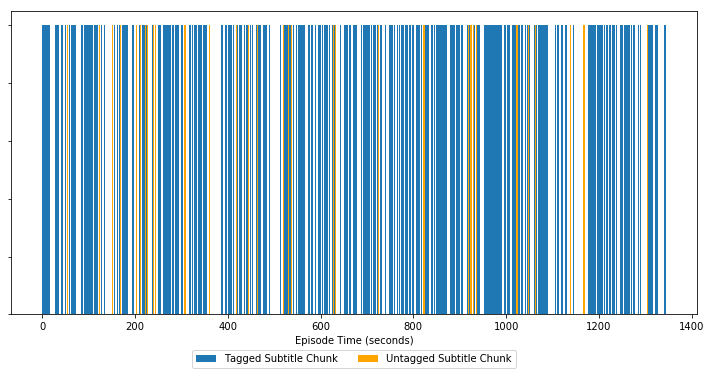

In [4]:
%matplotlib inline
%reload_ext autoreload
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.autolayout'] = True
import numpy as np
from math import ceil

def visualize_tagged_subs_time(subtitles):
    ms_to_frame = lambda ms: int(ms/1000)
    
    end_time = ceil(ms_to_frame(subtitles[-1].end_time))
    tagged_state = np.zeros(end_time)
    untagged_state = np.zeros(end_time)
    fix, ax = plt.subplots()
    for s in subtitles:
        start_index = ms_to_frame(s.start_time)
        end_index = ms_to_frame(s.end_time)
        if s.character is None:
            untagged_state[start_index:end_index] = 1
        else:
            tagged_state[start_index:end_index] = 1
    
    ax.bar(range(len(tagged_state)), tagged_state, width=1.0, label='Tagged Subtitle Chunk')
    ax.bar(range(len(tagged_state)), untagged_state, width=1.0, color='orange', label='Untagged Subtitle Chunk')
    ax.set_yticklabels([])
    plt.xlabel('Episode Time (seconds)')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=False, ncol=2)
    plt.show()

def visualize_tagged_subs(subtitles):
    tagged = 0
    untagged = 0
    for s in subtitles:
        if s.character is None:
            untagged += 1
        else:
            tagged += 1
    
    labels = ["Untagged", "Tagged"]
    values = np.asarray([untagged, tagged])
    fig, ax = plt.subplots()
    ax.pie(values, labels=labels, autopct='%1.1f%%')
    ax.axis('equal')
    plt.show()
# visualize_tagged_subs_time(e.subtitles)

def visualize_tagged_proportion(subtitles):
    total_time = subtitles[-1].end_time
    tagged_time = 0
    untagged_time = 0
    for s in subtitles:
        duration = s.duration
        total_time -= duration
        if s.character is None:
            untagged_time += duration
        else:
            tagged_time += duration
    
    labels = ["Untagged Subtitle", "Tagged Subtitle", "No Subtitle"]
    values = np.asarray([untagged_time, tagged_time, total_time])
    fig, ax = plt.subplots()
    width = 10
    b_u = ax.bar(0, untagged_time/60.0, width, label='Untagged Subtitle', color='dodgerblue')
    b_t = ax.bar(10, tagged_time/60.0, width, label='Tagged Subtitle', color='darkorange')
    b_n = ax.bar(20, total_time/60.0, width, label='No Subtitle', color='green')
    ax.set_ylabel('Minutes')
    ax.set_xticks([])
    ax.legend()
#     ax.bar(values, labels=labels, autopct='%1.1f%%')
#     ax.axis('equal')
    plt.show()
    
# visualize_tagged_proportion(e.subtitles)
# visualize_tagged_subs(e.subtitles)
visualize_tagged_subs_time(e.subtitles)
# print(len(e.subtitles))

In [ ]:
sub_duration = sum([s.duration for s in e.subtitles if s.character is not None])/1000/60
episode_duration = 21+42/60

print(sub_duration)
print(sub_duration/episode_duration)


/home/philip/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


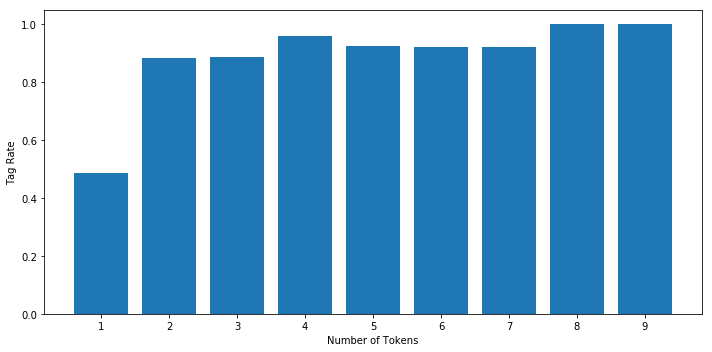

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
total_count = Counter()
tag_count = Counter()


for s in e.subtitles:
    num_tokens = len(s.tokens)
    total_count[num_tokens] += 1
    if s.character is not None:
        tag_count[num_tokens] += 1
    else:
        tag_count[num_tokens] += 0

num_tokens = []
ratios = []
for nt, total in total_count.items():
    num_tokens.append(nt)
    ratios.append(tag_count[nt]/total)


num_tokens_sorted, ratios_sorted = zip(*sorted(zip(num_tokens,ratios), key=lambda pair: pair[0]))
fig, ax = plt.subplots()
ax.bar(num_tokens_sorted[1:], ratios_sorted[1:])
plt.xticks(num_tokens_sorted[1:])
plt.xlabel('Number of Tokens')
plt.ylabel('Tag Rate')
plt.show()


[0.9253731343283582,
 0.8840579710144928,
 0.9230769230769231,
 0.8888888888888888,
 0.9230769230769231,
 1.0,
 0.48484848484848486,
 0.958904109589041,
 1.0,
 0.0]